# AWS Machine Learning Blog

## Creating neural time series models with Gluon Time Series 

by Jan Gasthaus, Alexander Alexandrov, Michael Bohlke-Schneider, Danielle Robinson, David Salinas, Valentin Flunkert, Konstantinos Benidis, Syama Rangapuram, Richard Lee, Jasper Schulz, Lorenzo Stella, Tim Januschowski, and Bernie Wang | on 03 JUN 2019

- [Link](https://aws.amazon.com/de/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/)
- Motivation: [Open source release of Gluon Time Series](https://aws.amazon.com/blogs/opensource/gluon-time-series-open-source-time-series-modeling-toolkit) [(GluonTS)](https://github.com/awslabs/gluon-ts).
- GluonTS is a Python toolkit for building, evaluating, and comparing deep learning-based time series models
- Based on Gluon interface to Apache MXNet.

### Time series modeling use cases

Collecting time series to gain insights to the following questions:

- How will the time series evolve in the future? **Forecasting**
- Is the behavior of the time series in a given period abnormal? **Anomaly detection**
- Which group does a given time series belong to? **Time series classification**
- Some measurements are missing, what were their values? **Imputation**

### GluonTS key functionality and components

Components: 

- Recurrent neural networks based on Long Short-Term Memory (LSTM) cells, convolutions, and attention mechanisms. 
- Apache MXNet for developing and experimenting with models. 

GluonTS provdies time series modeling-specific components on top of the GLuon interface to MXNet: 

- Higher-level components for building new models
- Data loading and iterators for time series data
 - i.e. a mechanism for transforming the data before it is supplied to the model
- Reference implementations of several state-of-the-art neural forecasting models
- Tools for evaluating and comparing forecasting models

### GluonTS for time series forecasting

- Example: [DeepAREstimator](https://github.com/awslabs/gluon-ts/blob/master/src/gluonts/model/deepar/_estimator.py#L37)

Trained on one or more time series, the model predicts the next `prediction_length` values given the preceding `context_length` values. 

- Model parametrizes a parametric probability distribution for each output position --> Probabilistic forecasting

GluonTS uses an `Estimator` / `Predictor` pair of abstractions, similar to other ml frameworks. The `Estimator` represents a model that can be trained on a dataset to yield a `Predictor`. This `Predictor` can be used to make predictions on unseen data. 

**To do:** 

- Instantiate a `DeepAREstimator` object
- provide a few hyperparameters
 - Time series frequency (here, `freq="5min")
 - Prediction length (36 time points, i.e. 180 minutes or 3 hours)
 
Also, a `Trainer` object can be used to configure the details of the training process to configure more aspects of the model by providing more hyperparameters as arguments. 

In [1]:
# import libraries
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

# instantiate estimator object
estimator = DeepAREstimator(freq="5min",
                            prediction_length=36,
                            trainer=Trainer(epochs=10))

INFO:root:Using CPU
INFO:root:Using CPU


### Model training on a real dataset

- Ready to train the "DeepAREstimator" object, i.e. the model
- Use of freely available dataset on the volume of tweets mentioning AMZN ticker symbol


In [2]:
# import standard libraries
import pandas as pd
import matplotlib.pyplot as plt

# specify url and download dataframe
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = pd.read_csv(url, header=0, index_col=0)

df.head()

,value
timestamp,
2015-02-26 21:42:53,57
2015-02-26 21:47:53,43
2015-02-26 21:52:53,55
2015-02-26 21:57:53,64
2015-02-26 22:02:53,93


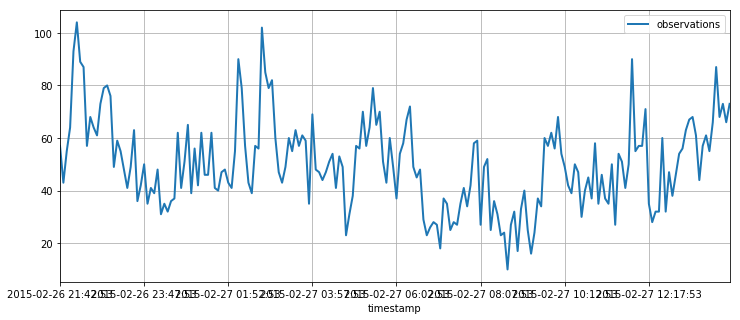

In [7]:
# plot first 200 observations
df[:200].plot(figsize=(12, 5), linewidth=2)
plt.grid()
plt.legend(["observations"])
plt.show()

GluonTS provides a `Dataset` abstraction for providing uniform access to data across different input formats. 

**To do:**

- Use `ListDataset` to access data stored in memory as a list of dictionaries

Any `Dataset` in GluonTS is an `Iterable` over dictionaries mapping string keys to arbitrary values. 

- Truncate the data up to April 5, 2015.

Data past this date is used later for testing the model


In [12]:
print(df.index[0])

2015-02-26 21:42:53


In [16]:
# import
from gluonts.dataset.common import ListDataset

training_data = ListDataset(
    [{"start": df.index[0], "target": df.value[:"2015-04-05 00:00:00"]}],
    freq = "5min"
)


In [18]:
list(training_data)

[{'start': Timestamp('2015-02-26 21:40:00', freq='5T'),
  'target': array([57., 43., 55., ..., 44., 61., 59.], dtype=float32),
  'source': SourceContext(source='list_data', row=1)}]

**To do:**

- Use the `estimator` and call its `train` method. 

After the training process the `Predictor` can be used for making forecasts

In [19]:
predictor = estimator.train(training_data=training_data)

INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  3.91it/s, avg_epoch_loss=4.4]
INFO:root:Epoch[0] Elapsed time 12.793 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.397877
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:11<00:00,  4.38it/s, avg_epoch_loss=4.07]
INFO:root:Epoch[1] Elapsed time 11.410 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.071247
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:10<00:00,  4.87it/s, avg_epoch_loss=4.02]
INFO:root:Epoch[2] Elapsed time 10.267 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.019393
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:11<00:00,  4.53it/s, avg_epoch_loss=4]
INFO:root:Epoch[3] Elapsed time 11.031 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.001857
INFO:root:Epoch[4] Learning rate is 0.001


### Model evaluation

**To do:**

- Use the `predictor` to plot the model's forecasts on time ranges that start after the last time point seen during training. 
- Create a few test instances by taking data past the time range previously used for training. 

In [24]:
test_data = ListDataset(
    [
        {"start": df.index[0], "target": df.value[:"2015-04-10 03:00:00"]},
        {"start": df.index[0], "target": df.value[:"2015-04-15 18:00:00"]},
        {"start": df.index[0], "target": df.value[:"2015-04-20 12:00:00"]}
    ],
    freq="5min"
)


In [27]:
list(test_data)

[{'start': Timestamp('2015-02-26 21:40:00', freq='5T'),
  'target': array([57., 43., 55., ..., 59., 39., 46.], dtype=float32),
  'source': SourceContext(source='list_data', row=1)},
 {'start': Timestamp('2015-02-26 21:40:00', freq='5T'),
  'target': array([57., 43., 55., ..., 53., 80., 83.], dtype=float32),
  'source': SourceContext(source='list_data', row=2)},
 {'start': Timestamp('2015-02-26 21:40:00', freq='5T'),
  'target': array([57., 43., 55., ..., 56., 41., 40.], dtype=float32),
  'source': SourceContext(source='list_data', row=3)}]

**Notes**

- Model produces probabilistic predictions (confidence of the model).

#### `itertools.islice` 

- Functions creating iterators for efficient looping
- [islice](https://docs.python.org/3/library/itertools.html#itertools.islice) - Make an iterator that returns selected elements from the iterable. 

#### `gluonts.evaluation.backtest.make_evaluation_predictions`

- [make_evaluation_predictions](https://gluon-ts.mxnet.io/api/gluonts/gluonts.evaluation.backtest.html#gluonts.evaluation.backtest.make_evaluation_predictions)
- Return predictions on the last portion of predict_length time units of the target
- Can be used in evaluation where accuracy is evaluated on the last portion of the target (time series)

Parameters:

- `dataset` - Dataset where the evaluation will happen. ONly the portion excluding the prediction_length portion is used when making prediction.
- `predictor` - Model used to draw predictions
- `num_eval_samples` - Number of samples to draw on the model when evaluating

In [75]:
# import islice
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

# define plot function
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

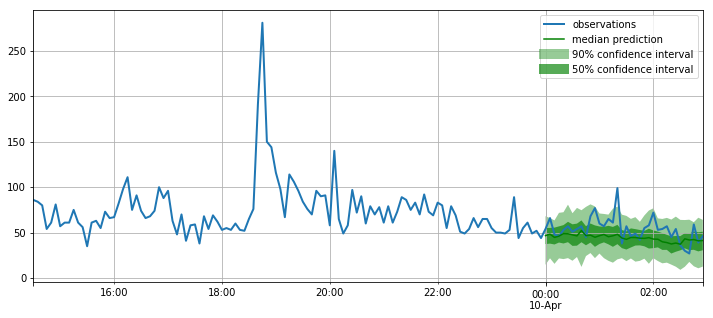

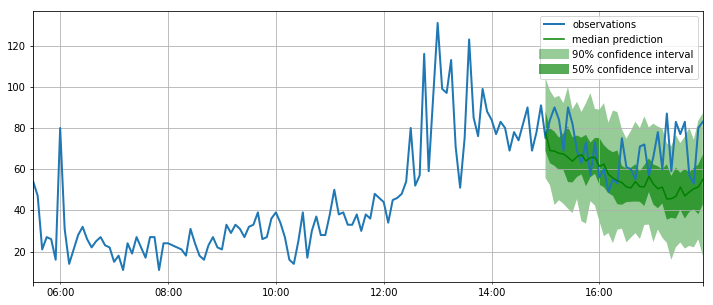

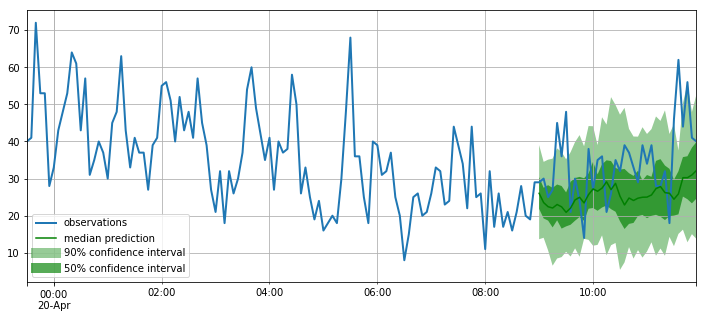

In [76]:
# get forecasts and respective intervals
forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)

# plot the forecasts using previously defined function
plot_forecasts(tss, forecasts, past_length=150, num_plots=3)

**Notes:**

- Now what? Quantitative evaluation!

GluonTS provides an `Evaluator` component, which performs the evaluation of this model. 

**To do:** 

- Use the `Evaluator` component to perform model evaluation

#### `gluonts.evaluation.Evaluator`

- Evaluator class, to compute accuracy metrics by comparing the observations to forecasts. 

Parameters: 

- **quantiles** - list of string of the form `p10` or floats in `[0,1]` with the quantile levels.
- **seasonality** - seasonality to use for seasonal_error, if nothing is passed uses the default seasonality for the given frequency as returned by get_seasonality.
- **alpha** - parameter of the MSIS metric from M4 competition that defines the confidence interval for alpha=0.05 the 95% interval, is considered in the metric, see https://www.m4.unic.ac.cy/wp-content/uploads/2018/03/M4 - Competitors-Guide.pdf for more detail on MSIS.

#### iter()

- The iter() method creates an object which can be iterated one element at a time.
- These objects are useful when coupled with loops like `for loop` or `while loop`

Syntax: 

```python
iter(object[, sentinel])
```

Parameters: 

- **object** - object whose iterator has to be created
- **sentinel (optional)** - special value that is used to represent the end of a sequence



In [79]:
### Example: How iter() works in Python
vowels = ["a", "e", "i", "o", "u"]

# crate iterator object
vowelsIter = iter(vowels)

# iterate over it, one element at a time
print(next(vowelsIter))
print(next(vowelsIter))
print(next(vowelsIter))<


a
e
i


In [80]:
from gluonts.evaluation import Evaluator

# instantiate Evaluator, median
# 2016 <- 7 days of 5 min intervals
evaluator = Evaluator(quantiles=[0.5], seasonality=2016)

# get aggregated metrics (one metric for all series), 
# get item-specific metrics (many metrics for one series)
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), )

agg_metrics

Running evaluation: 3it [00:00,  8.96it/s]


{'MSE': 224.5423583984375,
 'abs_error': 1256.0730285644531,
 'abs_target_sum': 5658.0,
 'abs_target_mean': 52.38888888888889,
 'seasonal_error': 18.833625618877182,
 'MASE': 0.6171229602208342,
 'sMAPE': 0.24493289288093026,
 'MSIS': 24.68491924848817,
 'QuantileLoss[0.5]': 1256.073034286499,
 'Coverage[0.5]': 0.2222222222222222,
 'RMSE': 14.984737515166474,
 'NRMSE': 0.28602892393743,
 'ND': 0.22199947482581356,
 'wQuantileLoss[0.5]': 0.2219994758371331,
 'mean_wQuantileLoss': 0.2219994758371331,
 'MAE_Coverage': 0.2777777777777778}

**Notes**

Compare these metrics against those produced by other models such as the [**seasonal naive method**](https://otexts.com/fpp2/simple-methods.html) or other models from the [gluonts.model](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.html) package. The **seasonal naive method** assumes that the data has a fixed seasonality, and produces forecasts by copying past observations based on it. 

#### `gluonts.model.seasonal_naive.SeasonalNaivePredictor`

Seasonal naive forecaster. 

Parameters: 

- **freq** - Frequency of the input data
- **prediction_length** - Number of time points to predict
- **season_length** - Length of the seasonality pattern of the input data


**To do**

- Apply **seasonal naive method** to the data and compare with the **DeepAR** Estimator


In [82]:
from gluonts.model.seasonal_naive import SeasonalNaivePredictor

# instantiate predictor 
seasonal_predictor_1W = SeasonalNaivePredictor(freq="5min", 
                                               prediction_length=36, 
                                               season_length=2016)
# forecasts
forecast_it, ts_it = make_evaluation_predictions(test_data,
                                                 predictor=seasonal_predictor_1W,
                                                 num_eval_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)

# get metrics using evaluator 
agg_metrics_seasonal, item_metrics_seasonal = evaluator(iter(tss), 
                                                        iter(forecasts),
                                                        num_series=len(test_data))

df_metrics = pd.DataFrame.join(
    pd.DataFrame.from_dict(agg_metrics, orient='index').rename(columns={0: "DeepAR"}),
    pd.DataFrame.from_dict(agg_metrics_seasonal, orient='index').rename(columns={0: "Seasonal naive"})
)
df_metrics.loc[["MASE", "sMAPE", "RMSE"]]

Running evaluation: 100%|██████████| 3/3 [00:00<00:00, 107.22it/s]


,DeepAR,Seasonal naive
MASE,0.617123,1.024993
sMAPE,0.244933,0.341459
RMSE,14.984738,28.481475


**Notes**

These metrics suggests that the **DeepAR** method seems to be more accurate on this dataset.

In [83]:
print("Done!")

Done!
